# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [2]:
# Сохраним датасет в переменную df и выведем первые 5 строк
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
# Постотрим общую информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
# Посмотрим количество пользователей по тарифам в нашей выборке
print(f'Количество пользователей тарифом Ультра: {len(df[df["is_ultra"] == 1])}')
print(f'Количество пользователей тарифом Смарт: {len(df[df["is_ultra"] == 0])}')

Количество пользователей тарифом Ультра: 985
Количество пользователей тарифом Смарт: 2229


Датасет состоит из 5 столбцов:
- `calls` - количество звонков;
- `minutes` - суммарная длительность звонков в минутах;
- `messages` - количество SMS-сообщений;
- `mb_used` - израсходованный интернет-трафик в Мб;
- `is_ultra` - каким тарифом пользовался в течении месяца ("Ультра" - 1, "Смарт" - 0).

Данные в столбце `is_ultra` для нас будут целевыми, т.е по значениями столбцов `calls`, `minutes`, `messages` и `mb_used` будет строиться рекомендательная система тарифов.

В нашей выборке пользователей с тарифом Смарт более чем в 2 раза больше, чем пользователей с тарифом Ультра.

Мы будем решать задачу классификации для этого будем использовать следующие модели машинного обучения:
- Дерево решений;
- Случайный лес;
- Логистическая регрессия.

## Разбейте данные на выборки

### Разобъем датасет на тренировочную, валидационную и тестовую выборки

In [5]:
# Разделим датасет на два датасета features - признаки, target - целевой признак
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Выделим из данных тренировочные данные, в размере 60% от всех данных. Остальные 40% данных поделим на попалам, чтобы получить тестовые и валидационные данные.

В результате мы получим:
- Тренировочные данные в размере 60% от изначального датасета;
- Валидационные данные в размере 20% от изначального датасета;
- Тестовые данные в размере 20% от изначального датасета;

In [6]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, 
                                                                                        target, 
                                                                                        random_state=123, 
                                                                                        train_size=0.6)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,
                                                                            target_valid_test,
                                                                            random_state=123,
                                                                            test_size=0.5)

In [7]:
# Выведем форму датасетов каждому датасету
print(f'Тренировочные данные: призники - {features_train.shape}, целевой признак - {target_train.shape}')
print(f'Валидационные данные: призники - {features_valid.shape}, целевой признак - {target_valid.shape}')
print(f'Тестовые данный: призники - {features_test.shape}, целевой признак - {target_test.shape}')

Тренировочные данные: призники - (1928, 4), целевой признак - (1928,)
Валидационные данные: призники - (643, 4), целевой признак - (643,)
Тестовые данный: призники - (643, 4), целевой признак - (643,)


**Вывод:**
1. Мы разбили изначальный датасет на датасет с признками и датасет с целевыми признаками.
2. Разделили полученные датасеты на 3 выборки:
- Обучающую - 60% от изначального датасета;
- Валидационную - 20% и от изначального датасета;
- Тестовую - 20% от изначального датасета.

## Исследуйте модели

### Дерево решений

Построим модель "Дерево решений" (DecisionTreeClassifier). 

Переберем деревья глубиной от 1 до 10 и выберем наилучшее

In [65]:
best_tree_model = None
best_tree_depth = 0
best_tree_accuracy = 0
best_tree_splitter = None
best_min_salmple_leaf = 0

for splitter in ('best', 'random'):
    for depth in range(1, 11):
        for sample in range(2, 5, 1):
            tree_model = DecisionTreeClassifier(max_depth=depth,
                                                random_state=123,
                                                splitter=splitter,
                                                min_samples_leaf=sample
                                               )
            tree_model.fit(features_train, target_train)
            prediction_valid = tree_model.predict(features_valid)
            result = accuracy_score(target_valid, prediction_valid)
            if result > best_tree_accuracy:
                best_tree_accuracy = result
                best_tree_model = tree_model
                best_tree_depth = depth
                best_tree_splitter = splitter
                best_min_salmple_leaf = sample

print(f"""
Лучший результат: {best_tree_accuracy}
Значения гиперпараметров:
   - max_depth: {best_tree_depth}
   - splitter: '{splitter}'
   - min_sample_leaf: {best_min_salmple_leaf}
   """)


Лучший результат: 0.8242612752721618
Значения гиперпараметров:
   - max_depth: 5
   - splitter: 'random'
   - min_sample_leaf: 3
   


### Случайный лес

Построим модель "Случайный лес" (RandomForestClassifier).

Переберем параметры `criterion`, `n_estimators`, `max_depth` и выберем наилучшую модель.

In [131]:
best_forest_model = None
best_forest_depth = 0
best_forest_est = 0
best_forest_accuracy = 0
best_forest_criterion = None
depths = list()
trees = list()
score = list()
best_feature = None

for crit in ('gini', 'entropy'):
    for depth in range(1, 11):
        for est in range(10, 101, 10):
            for feature in ('sqrt', 'log2', None, 'auto'):
                forest_model = RandomForestClassifier(criterion=crit,
                                                      n_estimators=est,
                                                      max_depth=depth,
                                                      max_features=feature,
                                                      random_state=123)
                forest_model.fit(features_train, target_train)
                prediction_valid = forest_model.predict(features_valid)
                result = accuracy_score(target_valid, prediction_valid)
                if result > best_forest_accuracy:
                    best_forest_accuracy = result
                    best_forest_model = forest_model
                    best_forest_depth = depth
                    best_forest_est = est
                    best_forest_criterion = crit
                    depths.append(depth)
                    trees.append(est)
                    score.append(result)
                    best_feature = feature

print(f'''
Лучший результат: {best_forest_accuracy}
Значения гиперпараметров:
    max_depth: {best_forest_depth}
    n_estimators: {best_forest_est}
    criterion: {best_forest_criterion}
    max_features: {best_feature}
    
    ''')



Лучший результат: 0.8351477449455676
Значения гиперпараметров:
    max_depth: 9
    n_estimators: 50
    criterion: gini
    max_features: None
    
    


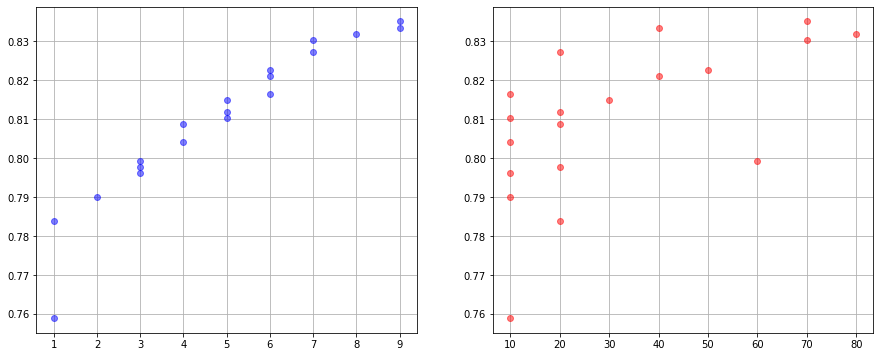

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(depths,
           score, 
           'o', color='b', alpha=0.5)
ax[0].grid()

ax[1].plot(trees,
            score, 
           'o', color='r', alpha=0.5)
ax[1].grid()

### Логистическая регрессия

Построим модель "Логистическая регрессия" (LogisticRegression). 

Рассмотрим модели с количеством итераций от 100 до 1000 и выберем лучшую модель.

In [64]:
best_log_reg_model = None
best_log_reg_iter = 0
best_log_reg_accuracy = 0

for iter in range(100, 1001, 100):
    log_reg_model = LogisticRegression(max_iter=iter,
                                           solver='lbfgs',
                                           random_state=123)
    log_reg_model.fit(features_train, target_train)
    prediction_valid = log_reg_model.predict(features_valid)
    result = accuracy_score(target_valid, prediction_valid)
    if result < best_forest_accuracy:
        best_log_reg_accuracy = result
        best_log_reg_model = log_reg_model
        best_log_reg_iter = iter

print(f'''
Лучший результат: {best_log_reg_accuracy}
    Количество итераций: {best_log_reg_iter}
    ''')


Лучший результат: 0.7589424572317263
    Количество итераций: 1000
    


**Вывод:**

**По валидационным данным лучшей моделью оказалась модель "Случайный лес" со следующими гипер-параметрами:**
 - accuracy_score: 0.8351477449455676
 - max_depth: 9
 - n_estimators: 70
 - criterion: 'gini'

## Проверьте модель на тестовой выборке

Проверим работу наилучшей полученной модели на тестовой выборке.

### Случайный лес

In [132]:
# Проверим результаты работы модели "Случайный лес" на тестовой выборке 
prediction_valid = best_forest_model.predict(features_test)
result = accuracy_score(target_test, prediction_valid)
print(f'Accuracy score модели "Случайный лес" на тестовой выборке по наилучшей модели: {result}')

Accuracy score модели "Случайный лес" на тестовой выборке по наилучшей модели: 0.7947122861586314


Вывод:

В результате проверки модели на тестовых данных **`accuracy_score` = 0.7947122861586314**



## (бонус) Проверьте модели на адекватность

В наших данных есть дисбаланс классов, пользователей с тарифом "Смарт" более чем в 2 раза больше, чем пользователей с тарифом "Ультра". Большинство алгоритмов машинного обучения работают лучше всего, когда количество образцов в каждом классе примерно одинаково.

Для проверки модели на адекватность будем использвать DummyClassifier.

In [15]:
dummy = DummyClassifier(strategy='most_frequent', random_state=123).fit(features_train, target_train)
dummy_pred = dummy.predict(features_test)
print('Accuracy score:', accuracy_score(target_test, dummy_pred))

Accuracy score: 0.6936236391912908


При проверке наших данных мы получили значение `accuracy_score` ниже, чем при использовании модели "Случайный лес", что говорит нам о правильности работы нашей модели.

## Общий вывод

**В ходе работы было выполнено:**
1. Полученные данные были разделены на 3 выборки:
- Обучающую - 60% от изначального датасета;
- Валидационную - 20% и от изначального датасета;
- Тестовую - 20% от изначального датасета.

2. Построены модели машинного обучения:
- Дерево решений;
- Случайный лес;
- Логистическая регрессия.

3. Проведена проверка моделей на тестовой выборке. Получены следующие результаты:
- Дерево решений - 0.7713841368584758
- Случайный лес - accuracy_score = 0.7947122861586314
- Логистическая регрессия - accuracy_score = 0.7309486780715396


4. Проведена проверка работы модели на адекватность.

**Наилучшая модель с результатом (accuracy_score = 0.795) для рекомендательной системы - Случайный лес со следующими гипер-параметрами:**
- max_depth: 9
- n_estimators: 70
- criterion: 'gini'
- max_features: None
